# Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import json
import requests
from scipy import stats

## Current Listing Data

In [2]:
curr_df = pd.read_csv('./update_df.csv')

In [3]:
curr_df[:3]

,property_id,prop_type,prop_sub_type,prop_status,price,baths_full,baths,beds,last_update,photo_count,...,state_code,county,lat,lon,neighborhood_name,buiding_size(sqft),lot_size(sqft),agent_id,agent_name,brand_name
0,M4046594895,condo,duplex_triplex,for_sale,249900,3.0,3,6.0,2020-10-13T17:54:05Z,9,...,PA,Philadelphia,39.974408,-75.243700,West Philadelphia,1632.0,1842.0,1291281.0,Ausra Anusauskas,Archstone Realty
1,M3939384476,condo,townhomes,for_sale,116800,1.0,1,3.0,2020-10-13T18:18:18Z,7,...,PA,Philadelphia,39.926283,-75.225382,Southwest Philadelphia,1092.0,992.0,347285.0,Dr Hanh Vo,Vihi Realty
2,M4036371277,condo,townhomes,for_sale,215000,1.0,2,3.0,2020-10-13T17:24:20Z,35,...,PA,Philadelphia,40.039721,-75.142100,Upper North District,1360.0,1501.0,NaN,Kevin Chen,Premium Realty Castor Inc


In [4]:
curr_df.rename(columns = {'postal_code':'zip_code'}, inplace=True)

## Historical Listing Data

In [5]:
hist_df = pd.read_csv('./hist_price_with_zip.csv')

In [6]:
hist_df.head()

,property_id,event_name,date,price,price_range_min,price_range_max,price_changed,sqft,datasource_name,source,listing,iso_date,listing_id,previous_event_price,postal_code
0,M3392201642,Price Changed,2020-10-17T17:00:00Z,355000,NaN,NaN,5000,1750,BrightMLS,MLS #PAPH935838,NaN,NaN,NaN,NaN,19116
1,M3392201642,Listed,2020-10-11T17:00:00Z,350000,NaN,NaN,0,1750,BrightMLS,MLS #PAPH935838,NaN,NaN,NaN,NaN,19116
2,M3164904583,Listed,2020-10-11T17:00:00Z,149900,NaN,NaN,0,1176,BrightMLS,MLS #PAPH944164,NaN,NaN,NaN,NaN,19143
3,M3164904583,Sold,2002-03-18T17:00:00Z,70500,NaN,NaN,0,1176,NaN,Public Record,NaN,NaN,NaN,NaN,19143
4,M3164904583,Sold,1988-09-21T17:00:00Z,33900,NaN,NaN,0,1176,NaN,Public Record,NaN,NaN,NaN,NaN,19143


In [7]:
# Remove 'T00:00:00Z' from 'date'
hist_df['date'] =  [re.sub('T(.*?)Z','', str(x)) for x in hist_df['date']]

In [8]:
# Covnert 'date' to a datetime object
hist_df['date'] = pd.to_datetime(hist_df['date'])

In [9]:
hist_df.rename(columns = {'postal_code':'zip_code'}, inplace=True)

### Subset properties listed from January 2019 - February 2020

In [10]:
# Subset July 2019 - February 2020
hist_19 = hist_df[hist_df['date'].isin(pd.date_range(start='2019-01-01', end='2020-02-29'))]

In [11]:
print('length of full hist_df =', len(hist_df))
print('length of df subset for January 2019 - February 2020 =', len(hist_19))
print('So we lose %d instsances after subsetting' % (len(hist_df) - len(hist_19)))

length of full hist_df = 60459
length of df subset for January 2019 - February 2020 = 5728
So we lose 54731 instsances after subsetting


### Drop the extra listing data, keep the most recent listing.

In [12]:
final_hist = hist_19.sort_values('date').drop_duplicates('property_id',keep='last')

In [13]:
print('After keeping only the last listed piece of data for each property')
print('in our final historical dataset, we are left with', len(final_hist['zip_code']), 'instances.')
print('The dataset for the current listings has', len(curr_df), 'instances.')

After keeping only the last listed piece of data for each property
in our final historical dataset, we are left with 2493 instances.
The dataset for the current listings has 9562 instances.


## Test outcomes by zip
<a id='covid'></a>

In [14]:
# Tests by zip
url = 'https://phl.carto.com/api/v2/sql?q=SELECT * FROM covid_cases_by_zip'
response = requests.request("GET", url)
test_zip = pd.json_normalize(response.json()['rows'])

In [15]:
test_zip.head()

,cartodb_id,the_geom,the_geom_webmercator,covid_status,zip_code,count,etl_timestamp
0,1,None,None,POS,19132,1132,2020-11-13T18:20:02Z
1,2,None,None,NEG,19104,25559,2020-11-13T18:20:02Z
2,3,None,None,NEG,19101,223,2020-11-13T18:20:02Z
3,4,None,None,POS,19128,807,2020-11-13T18:20:02Z
4,5,None,None,POS,19114,948,2020-11-13T18:20:02Z


In [16]:
# Subset for positive tests
pos_zip = test_zip[test_zip['covid_status'] == 'POS']

In [17]:
# Top 5 zips by count
top_5_zips = []

for i in pos_zip.sort_values('count', ascending=False)[:4]['zip_code']:
    top_5_zips.append(i)
    
top_5_zips

['19120', '19124', '19111', '19140']

In [18]:
# Bottom 5 zips by count
bottom_5_zips = []

for i in pos_zip.sort_values('count', ascending=False)[-4:]['zip_code']:
    bottom_5_zips.append(i)
    
bottom_5_zips

['19102', '19127', '19101', '19105']

### Subset the zip codes with the top 5 highest number of positive case counts, and bottom 5 lowest number of positive case counts..

In [20]:
top5_hist = final_hist[final_hist['zip_code'].isin(top_5_zips)]
bot5_hist = final_hist[final_hist['zip_code'].isin(bottom_5_zips)]

In [21]:
top5_curr = curr_df[curr_df['zip_code'].isin(top_5_zips)]
bot5_curr = curr_df[curr_df['zip_code'].isin(bottom_5_zips)]

# Statistical analysis on full datasets, and on datasets with some outliers removed.

### Boxplots - Full Datasets

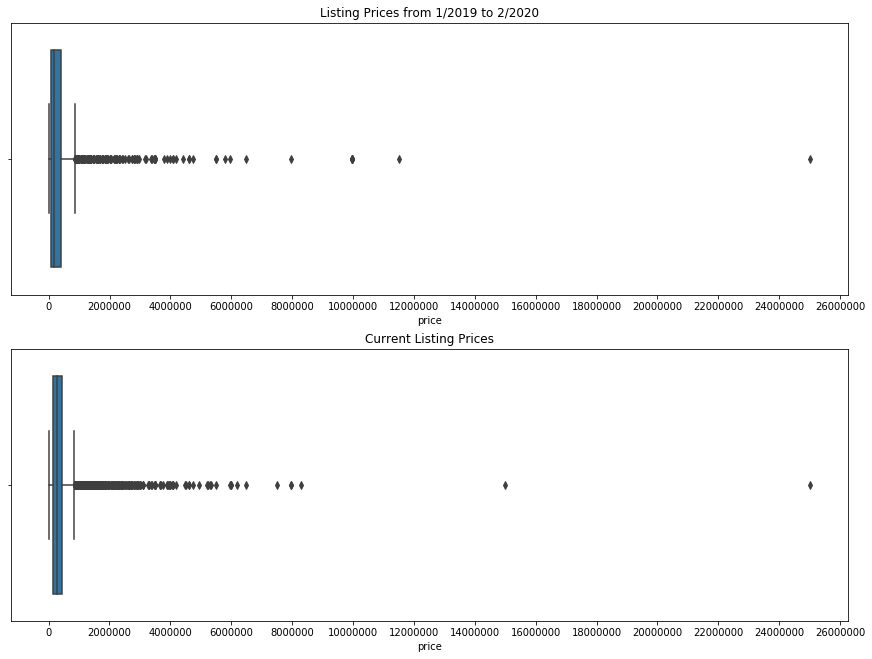

In [57]:
fig = plt.figure()
fig.set_figheight(10)
fig.set_figwidth(16)
ax = fig.add_subplot(2, 1, 1)
final_hist_prices_plot = sns.boxplot(final_hist['price'], ax=ax)
final_hist_prices_plot.set_title('Listing Prices from 1/2019 to 2/2020')
final_hist_prices_plot.ticklabel_format(style='plain', axis='x')
final_hist_prices_plot.set(xticks=np.arange(0, 26000001, 2000000))
ax = fig.add_subplot(2, 1, 2)
curr_prices_plot = sns.boxplot(curr_df['price'], ax=ax)
curr_prices_plot.set_title('Current Listing Prices')
curr_prices_plot.ticklabel_format(style='plain', axis='x')
curr_prices_plot.set(xticks=np.arange(0, 26000001, 2000000))
plt.show()

### Histograms - Full Datasets

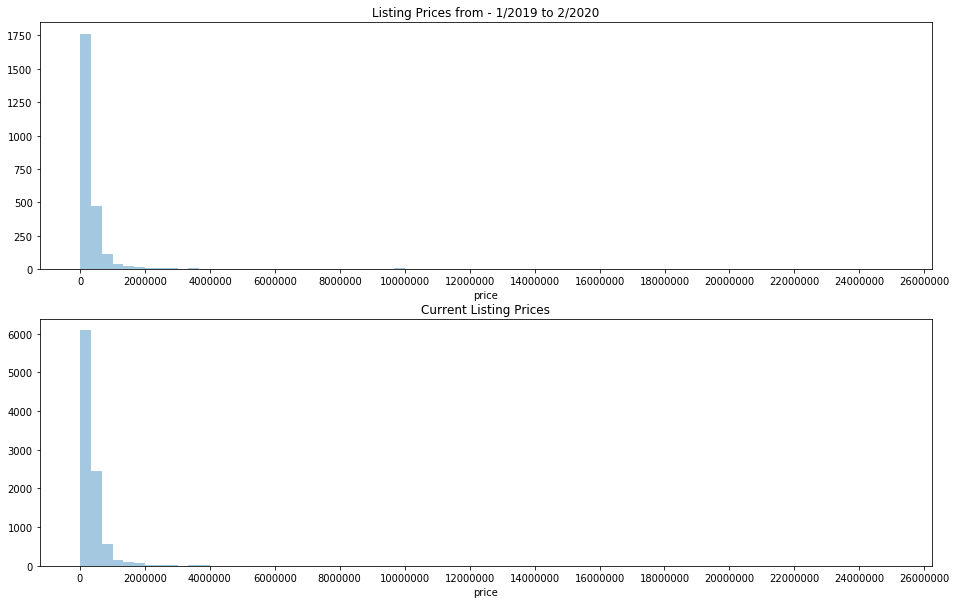

In [125]:
fig = plt.figure()
fig.set_figheight(10)
fig.set_figwidth(16)
ax = fig.add_subplot(2, 1, 1)
hist_prices_histo = sns.distplot(final_hist['price'], kde=False, bins=75)
hist_prices_histo.set_title('Listing Prices from - 1/2019 to 2/2020')
hist_prices_histo.set(xticks=np.arange(0, 26000001, 2000000))
hist_prices_histo.ticklabel_format(style='plain', axis='x')
ax = fig.add_subplot(2, 1, 2)
curr_prices_histo = sns.distplot(curr_df['price'], kde=False, bins=75)
curr_prices_histo.set_title('Current Listing Prices')
curr_prices_histo.set(xticks=np.arange(0, 26000001, 2000000))
curr_prices_histo.ticklabel_format(style='plain', axis='x')
plt.show()

In [26]:
print('Descriptive statistics for the full historical dataset.')
stats.describe(final_hist['price'])

Descriptive statistics for the full historical dataset.


DescribeResult(nobs=2493, minmax=(900, 25000000), mean=381891.5286803049, variance=854534661057.5542, skewness=12.2668021425143, kurtosis=241.80308075608949)

In [130]:
print('Descriptive statistics for the full current dataset.')
stats.describe(curr_df['price'])

Descriptive statistics for the full current dataset.


DescribeResult(nobs=9562, minmax=(6000, 25000000), mean=381703.5611796695, variance=313156718177.5901, skewness=14.452907462413856, kurtosis=469.3509268783856)

#### The above (slightly less obvious) results read as follows:
* nobs - Number of observations
* minmax - Tuple of the lowest price, and highest price
* skewness - A measure of how skewed the data is, perfectly normal distribution would equal zero
* kurtosis - A measure of how high the peak is in reference to its tails. (High kurtosis has long tails with a high peak - values spread far from the mean)

## Do we have equal variance for the full datasets?

In [99]:
print('Bartlett p-value =', stats.bartlett(final_hist['price'], curr_df['price'])[1], '\n')
print('Leven p-value =', stats.levene(final_hist['price'], curr_df['price'])[1], '\n')
print('Flinger p-value =', stats.fligner(final_hist['price'], curr_df['price'], center='mean')[1])

Bartlett p-value = 6.234360610688021e-259 

Leven p-value = 2.41525136944328e-06 

Flinger p-value = 1.659003770280044e-51


#### The small p-value in all three tests tells us that we do not have equal variance between the full datasets.

## Remove outliers in both datasets
* We'll choose to get rid of listings greater than $900,000.

In [28]:
final_hist2 = final_hist[final_hist['price'] < 900000]

In [29]:
curr_df2 = curr_df[curr_df['price'] < 900000]

In [30]:
print('These outliers only accounted for %.2f%% of our historical data and' % (1 - (len(final_hist2)/len(final_hist))))
print('%.2f%% of the current data.' % (1 - (len(curr_df2)/len(curr_df))))

These outliers only accounted for 0.07% of our historical data and
0.06% of the current data.


## Visualizing the data with some outliers removed:

### Boxplots - Outliers Removed

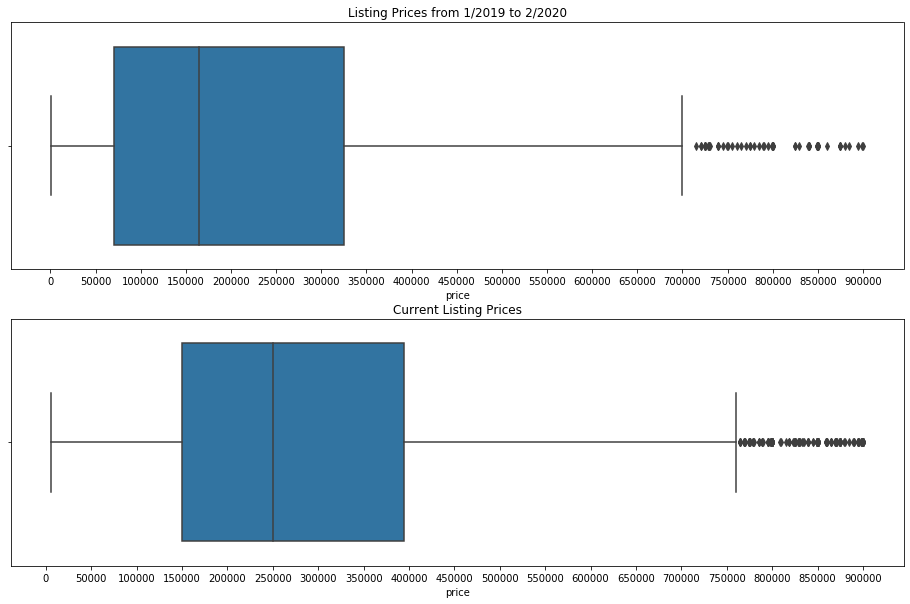

In [61]:
fig = plt.figure()
fig.set_figheight(10)
fig.set_figwidth(16)
ax = fig.add_subplot(2, 1, 1)
final_hist_prices_plot2 = sns.boxplot(final_hist2['price'], ax=ax)
final_hist_prices_plot2.set_title('Listing Prices from 1/2019 to 2/2020')
final_hist_prices_plot2.ticklabel_format(style='plain', axis='x')
final_hist_prices_plot2.set(xticks=np.arange(0, 900001, 50000))
ax = fig.add_subplot(2, 1, 2)
curr_prices_plot2 = sns.boxplot(curr_df2['price'], ax=ax)
curr_prices_plot2.set_title('Current Listing Prices')
curr_prices_plot2.ticklabel_format(style='plain', axis='x')
curr_prices_plot2.set(xticks=np.arange(0, 900001, 50000))
plt.show()

### Histograms - Outliers Removed

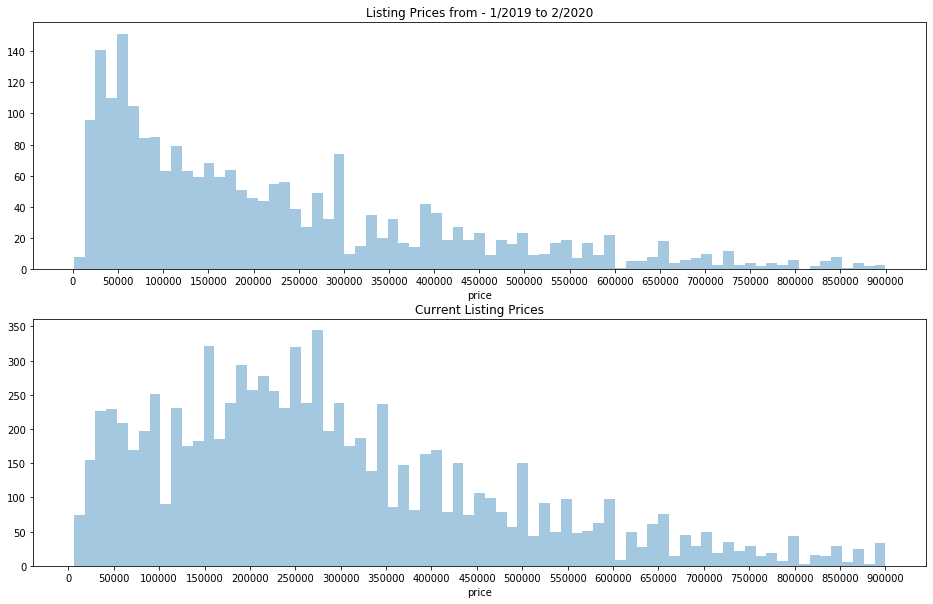

In [62]:
fig = plt.figure()
fig.set_figheight(10)
fig.set_figwidth(16)
ax = fig.add_subplot(2, 1, 1)
hist_prices_histo2 = sns.distplot(final_hist2['price'], kde=False, bins=75)
hist_prices_histo2.set_title('Listing Prices from - 1/2019 to 2/2020')
hist_prices_histo2.set(xticks=np.arange(0, 900001, 50000))
hist_prices_histo2.ticklabel_format(style='plain', axis='x')
ax = fig.add_subplot(2, 1, 2)
curr_prices_histo2 = sns.distplot(curr_df2['price'], kde=False, bins=75)
curr_prices_histo2.set_title('Current Listing Prices')
curr_prices_histo2.set(xticks=np.arange(0, 900001, 50000))
curr_prices_histo2.ticklabel_format(style='plain', axis='x')
plt.show()

In [63]:
print('Descriptive statistics for the historical data with some outliers removed.')
stats.describe(final_hist2['price'])

Descriptive statistics for the historical data with some outliers removed.


DescribeResult(nobs=2320, minmax=(900, 899900), mean=224190.11422413794, variance=37054673065.41816, skewness=1.1809450478949075, kurtosis=0.8331384196145772)

In [64]:
print('Descriptive statistics for the current data with some outliers removed.')
stats.describe(curr_df2['price'])

Descriptive statistics for the current data with some outliers removed.


DescribeResult(nobs=8984, minmax=(6000, 899999), mean=288463.20102404273, variance=35837855787.81599, skewness=0.8872424310694464, kurtosis=0.4016677938819764)

### Removing some of the outliers has made a clear impact on the skewness and kurtosis measures compared to these measures on the full dataset.

## Do we have equal variance for the datasets with some outliers removed?

In [98]:
print('Bartlett p-value =', stats.bartlett(final_hist2['price'], curr_df2['price'])[1], '\n')
print('Leven p-value =', stats.levene(final_hist2['price'], curr_df2['price'])[1], '\n')
print('Flinger p-value =', stats.fligner(final_hist2['price'], curr_df2['price'], center='mean')[1])

Bartlett p-value = 0.3092113193400671 

Leven p-value = 0.75985958622035 

Flinger p-value = 0.3400303507920644


### All three of the tests for equal varaince have large p-values, which suggests that we do have equal variance for our datasets with some outliers removed.

## Is there a difference between the mean of the historical data and the mean of the current data - with outliers removed?
* Null Hypothesis: The means are equal.
* Alternative Hypothesis: The means are not equal.

In [93]:
tstat, pval = stats.ttest_ind(final_hist2['price'], curr_df2['price'], equal_var=True)
mean, var, std = stats.bayes_mvs(final_hist2['price'], .95)
print('p-value =', pval)
print('95% Confidence interval for mean =', mean)

p-value = 2.1435395293392626e-47
95% Confidence interval for mean = Mean(statistic=224190.11422413794, minmax=(216358.84826528654, 232021.38018298935))


### The small p-value tells us that we can reject the null hypothesis that the means are equal. When considering the datasets with some outliers removed, we can conclude that the mean of listing prices before the pandemic is not equal to the mean of listing prices during the pandemic. However, the difference is actually not in the direction we had originally assumed:

In [148]:
diff = round(stats.describe(curr_df2['price'])[2] - stats.describe(final_hist2['price'])[2],2)
print("The mean of the real estate listings increased by $%d, during the pandemic" % diff)

The mean of the real estate listings increased by $64273, during the pandemic


### Keep in mind that this increase (\\$64273) takes into account the data we have for all of Philadelphia. We know from our [COVID data](#covid) that some zip codes were hit much harder than other. Let's investigate a little further and see if positive case count might have an impact on mean listing price.

------------------------------

# Statistical analysis on the zip codes with the top 5 highest number of positive cases, and bottom 5 lowest number of positive cases.

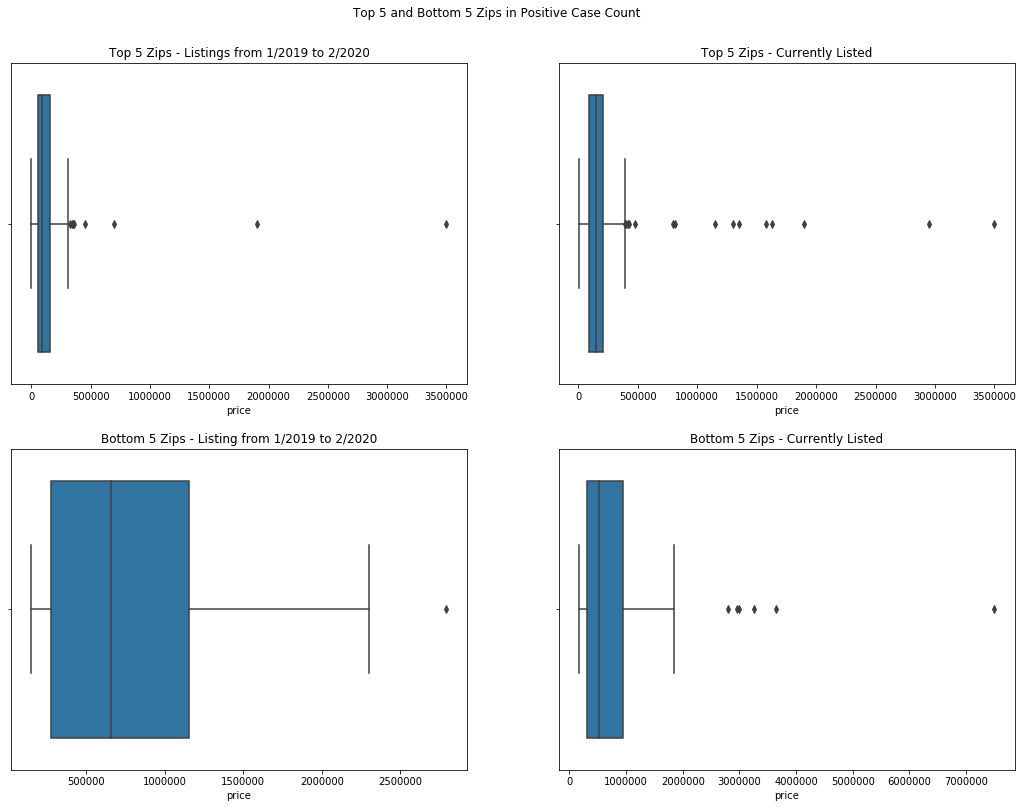

In [115]:
fig = plt.figure()
fig.suptitle("Top 5 and Bottom 5 Zips in Positive Case Count", y=.94)
fig.set_figheight(13)
fig.set_figwidth(18)
ax = fig.add_subplot(2, 2, 1)
top5_hist_prices_plot = sns.boxplot(top5_hist['price'], ax=ax)
top5_hist_prices_plot.set_title('Top 5 Zips - Listings from 1/2019 to 2/2020')
ax = fig.add_subplot(2, 2, 2)
top5_curr_prices_plot = sns.boxplot(top5_curr['price'], ax=ax)
top5_curr_prices_plot.set_title('Top 5 Zips - Currently Listed')
ax = fig.add_subplot(2, 2, 3)
bot5_hist_prices_plot = sns.boxplot(bot5_hist['price'], ax=ax)
bot5_hist_prices_plot.set_title('Bottom 5 Zips - Listing from 1/2019 to 2/2020')
ax = fig.add_subplot(2, 2, 4)
bot5_curr_prices_plot = sns.boxplot(bot5_curr['price'], ax=ax)
bot5_curr_prices_plot.set_title('Bottom 5 Zips - Currently Listed')
plt.show()

### Our top 5 and bottom 5 data were subset from the previous datasets before outlier removal; we see that these top 5 and botton 5 subsets also have some outliers to deal with. Our top 5 data seems to have outliers in similar range between the current and historical data, so we'll choose to get rid of listing greater than \\$600\,000 there\.

### On the other hand\, our bottom 5 data has\, possibly\, 1 outlier in the historical data round \$2\,800\,000. However\, the current data for bottom 5 has several outliers ranging from about \\$2\,750\,000 all the way to about \\$7\,500\,000\! With that said, we'll get rid of all listings with prices greater than \\$3,000,000 for both current and historical bottom 5 datasets.

In [42]:
top5_hist2 = top5_hist[top5_hist['price'] < 600000]
top5_curr2 = top5_curr[top5_curr['price'] < 600000]
bot5_hist2 = bot5_hist[bot5_hist['price'] < 3000000]
bot5_curr2 = bot5_curr[bot5_curr['price'] < 3000000]

### Now let's see what these plots looks like

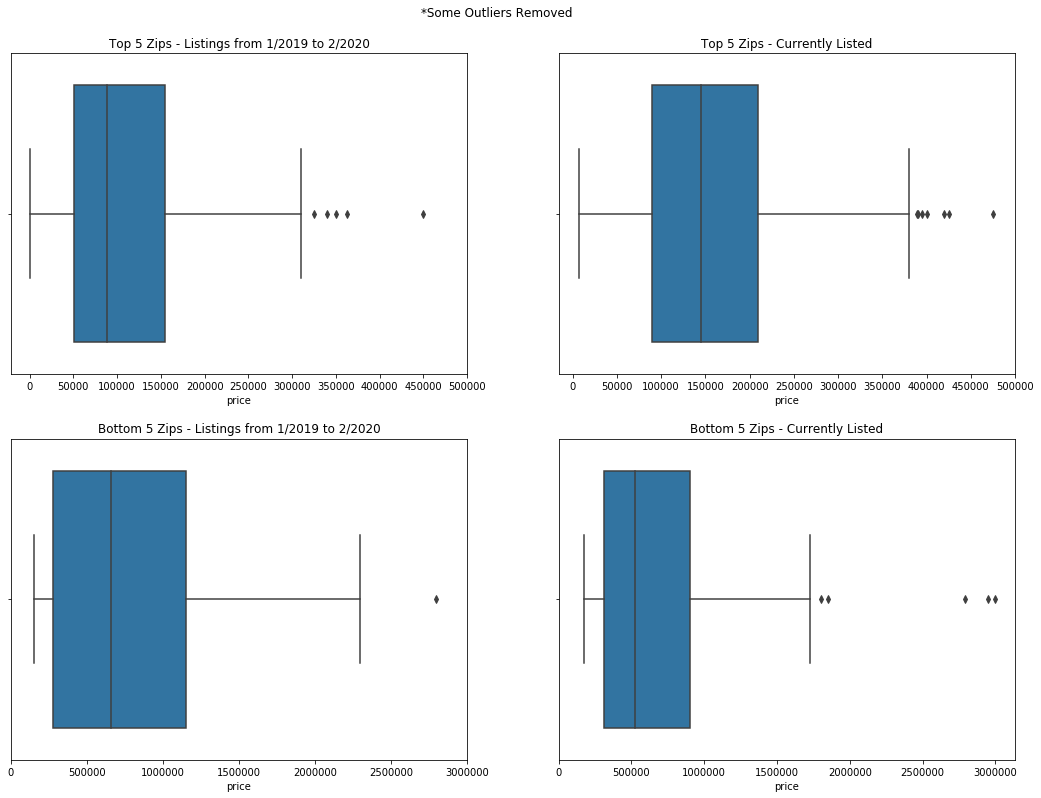

In [117]:
fig = plt.figure()
fig.suptitle("*Some Outliers Removed", y=.93)
fig.set_figheight(13)
fig.set_figwidth(18)
ax = fig.add_subplot(2, 2, 1)
top5_hist2_prices_plot = sns.boxplot(top5_hist2['price'], ax=ax)
top5_hist2_prices_plot.set_title('Top 5 Zips - Listings from 1/2019 to 2/2020')
top5_hist2_prices_plot.set(xticks=np.arange(0, 500001, 50000))
ax = fig.add_subplot(2, 2, 2)
top5_curr2_prices_plot = sns.boxplot(top5_curr2['price'], ax=ax)
top5_curr2_prices_plot.set_title('Top 5 Zips - Currently Listed')
top5_curr2_prices_plot.set(xticks=np.arange(0, 500001, 50000))
ax = fig.add_subplot(2, 2, 3)
bot5_hist2_prices_plot = sns.boxplot(bot5_hist2['price'], ax=ax)
bot5_hist2_prices_plot.set_title('Bottom 5 Zips - Listings from 1/2019 to 2/2020')
bot5_hist2_prices_plot.set(xticks=np.arange(0,3250001, 500000))
ax = fig.add_subplot(2, 2, 4)
bot5_curr2_prices_plot = sns.boxplot(bot5_curr2['price'], ax=ax)
bot5_curr2_prices_plot.set_title('Bottom 5 Zips - Currently Listed')
bot5_curr2_prices_plot.set(xticks=np.arange(0,3250001, 500000))
plt.show()

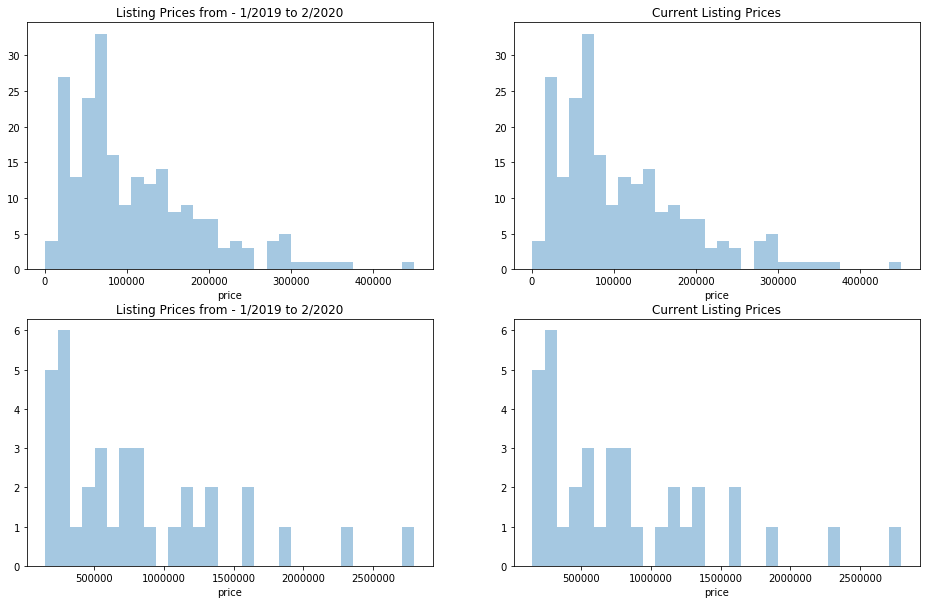

In [120]:
fig = plt.figure()
fig.set_figheight(10)
fig.set_figwidth(16)
ax = fig.add_subplot(2, 2, 1)
top5_prices_histo2 = sns.distplot(top5_hist2['price'], kde=False, bins=30)
top5_prices_histo2.set_title('Listing Prices from - 1/2019 to 2/2020')
# top5_prices_histo2.set(xticks=np.arange(0, 900001, 50000))
top5_prices_histo2.ticklabel_format(style='plain', axis='x')
ax = fig.add_subplot(2, 2, 2)
top5_prices_histo2 = sns.distplot(top5_hist2['price'], kde=False, bins=30)
top5_prices_histo2.set_title('Current Listing Prices')
# top5_prices_histo2.set(xticks=np.arange(0, 900001, 50000))
top5_prices_histo2.ticklabel_format(style='plain', axis='x')
ax = fig.add_subplot(2, 2, 3)
bot5_prices_histo2 = sns.distplot(bot5_hist2['price'], kde=False, bins=30)
bot5_prices_histo2.set_title('Listing Prices from - 1/2019 to 2/2020')
# bot5_prices_histo2.set(xticks=np.arange(0, 900001, 50000))
bot5_prices_histo2.ticklabel_format(style='plain', axis='x')
ax = fig.add_subplot(2, 2, 4)
bot5_prices_histo2 = sns.distplot(bot5_hist2['price'], kde=False, bins=30)
bot5_prices_histo2.set_title('Current Listing Prices')
# bot5_prices_histo2.set(xticks=np.arange(0, 900001, 50000))
bot5_prices_histo2.ticklabel_format(style='plain', axis='x')
plt.show()

In [44]:
stats.ttest_ind(top5_hist['price'], top5_curr['price'])

Ttest_indResult(statistic=-2.0825892245436535, pvalue=0.03752709433818062)

In [45]:
stats.ttest_ind(bot5_hist['price'], bot5_curr['price'])

Ttest_indResult(statistic=0.4294647808608971, pvalue=0.6680015340737563)